# ***algo TABOU***

<ipython-input-16-116cf5f03120>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.


Original per‐patient makespan: 105


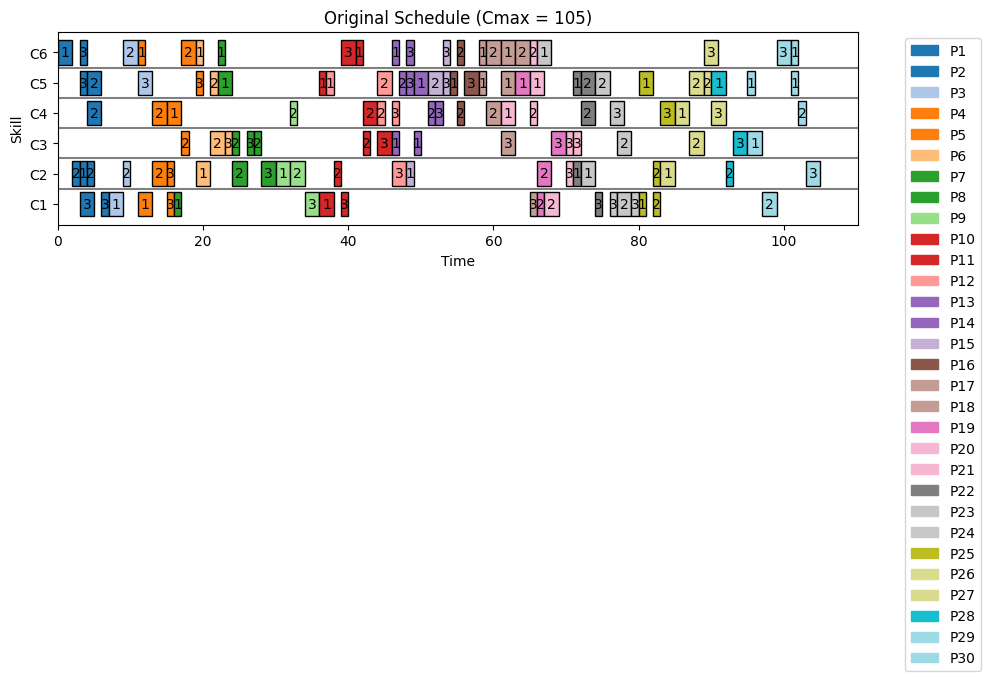

By‐stage makespan: 66


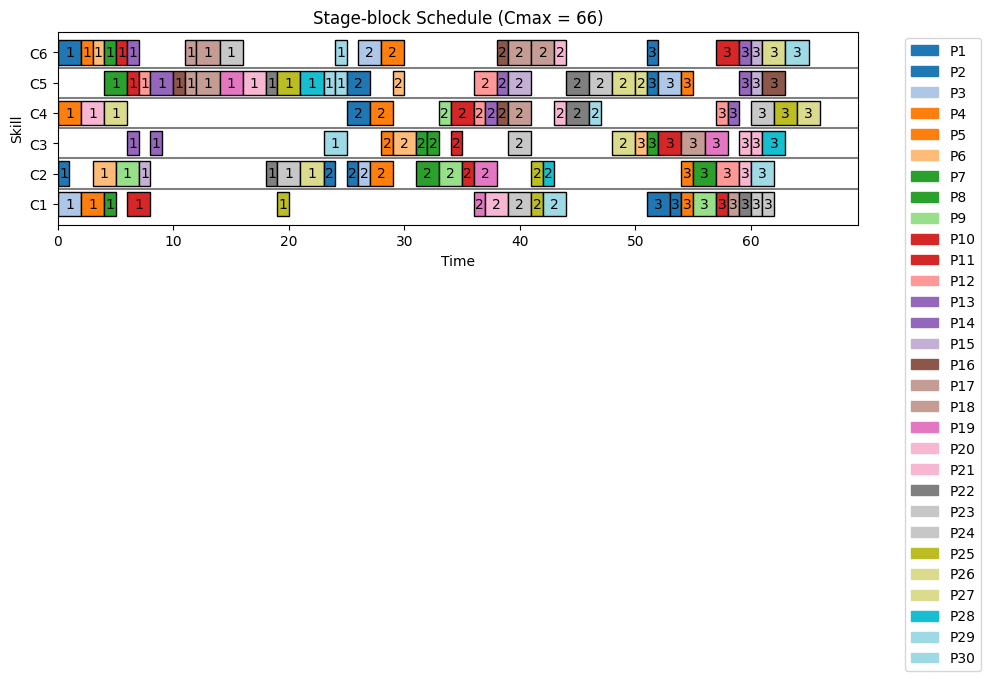

After Tabu Search makespan: 54


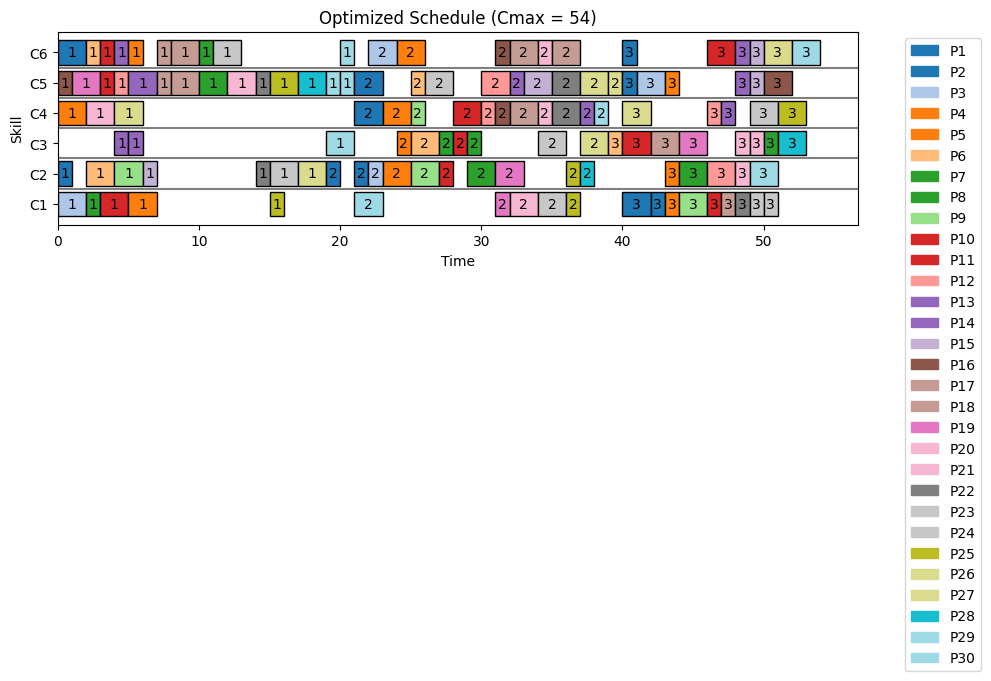

In [16]:
import random
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ── 1) Problem data ───────────────────────────────────────────────
patients = {
    1: [(1, {'C6': 2}), (2, {'C2': 1}), (3, {'C1': 2, 'C5': 1, 'C6': 1})],
    2: [(1, {'C2': 1}), (2, {'C2': 1, 'C5': 2, 'C4': 2}), (3, {'C1': 1})],
    3: [(1, {'C1': 2}), (2, {'C2': 1, 'C6': 2}), (3, {'C5': 2})],
    4: [(1, {'C1': 2, 'C6': 1}), (2, {'C2': 2, 'C4': 2}), (3, {'C1': 1, 'C2': 1})],
    5: [(1, {'C4': 2}), (2, {'C3': 1, 'C6': 2}), (3, {'C5': 1})],
    6: [(1, {'C2': 2, 'C6': 1}), (2, {'C3': 2, 'C5': 1}), (3, {'C3': 1})],
    7: [(1, {'C1': 1}), (2, {'C2': 2, 'C3': 1}), (3, {'C3': 1})],
    8: [(1, {'C5': 2, 'C6': 1}), (2, {'C3': 1}), (3, {'C2': 2})],
    9: [(1, {'C2': 2}), (2, {'C2': 2, 'C4': 1}), (3, {'C1': 2})],
    10: [(1, {'C1': 2, 'C5': 1}), (2, {'C2': 1}), (3, {'C1': 1, 'C6': 2})],
    11: [(1, {'C6': 1}), (2, {'C3': 1, 'C4': 2}), (3, {'C3': 2})],
    12: [(1, {'C5': 1}), (2, {'C4': 1, 'C5': 2}), (3, {'C2': 2, 'C4': 1})],
    13: [(1, {'C3': 1, 'C6': 1}), (2, {'C5': 1}), (3, {'C5': 1, 'C6': 1})],
    14: [(1, {'C3': 1, 'C5': 2}), (2, {'C4': 1}), (3, {'C4': 1})],
    15: [(1, {'C2': 1}), (2, {'C5': 2}), (3, {'C5': 1, 'C6': 1})],
    16: [(1, {'C5': 1}), (2, {'C6': 1, 'C4': 1}), (3, {'C5': 2})],
    17: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 2, 'C6': 2}), (3, {'C3': 2})],
    18: [(1, {'C6': 2, 'C5': 2}), (2, {'C6': 2}), (3, {'C1': 1})],
    19: [(1, {'C5': 2}), (2, {'C1': 1, 'C2': 2}), (3, {'C3': 2})],
    20: [(1, {'C5': 2}), (2, {'C1': 2}), (3, {'C2': 1, 'C3': 1})],
    21: [(1, {'C4': 2}), (2, {'C4': 1, 'C6': 1}), (3, {'C3': 1})],
    22: [(1, {'C2': 1, 'C5': 1}), (2, {'C4': 2, 'C5': 2}), (3, {'C1': 1})],
    23: [(1, {'C2': 2}), (2, {'C5': 2}), (3, {'C1': 1, 'C4': 2})],
    24: [(1, {'C6': 2}), (2, {'C1': 2, 'C3': 2}), (3, {'C1': 1})],
    25: [(1, {'C1': 1, 'C5': 2}), (2, {'C1': 1, 'C2': 1}), (3, {'C4': 2})],
    26: [(1, {'C4': 2}), (2, {'C3': 2, 'C5': 2}), (3, {'C6': 2})],
    27: [(1, {'C2': 2}), (2, {'C5': 1}), (3, {'C4': 2})],
    28: [(1, {'C5': 2}), (2, {'C2': 1}), (3, {'C3': 2})],
    29: [(1, {'C3': 2, 'C5': 1}), (2, {'C1': 2}), (3, {'C6': 2})],
    30: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 1}), (3, {'C2': 2})]
}

skills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.
patient_colors = {pid: mcolors.to_hex(cmap(i)) for i, pid in enumerate(patients)}


# Flatten all tasks once
all_tasks = []
for p, ops in patients.items():
    for op_id, needs in ops:
        all_tasks.append((p, op_id, needs))

max_stage = max(op for _, ops in patients.items() for op, _ in ops)


# ── 2) Decoder (same for all three) ──────────────────────────────
def build_schedule(order):
    schedule = {s:[] for s in skills}
    skill_free = {s:0 for s in skills}
    patient_free = {p:0 for p in patients}

    for (p, op, needs) in order:
        t0 = patient_free[p]
        for s,d in needs.items():
            t0 = max(t0, skill_free[s])
        for s,d in needs.items():
            start, end = t0, t0 + d
            skill_free[s] = end
            schedule[s].append((p, start, end, op))
        patient_free[p] = t0 + max(needs.values())

    Cmax = max(end for tasks in schedule.values() for (_,_,end,_) in tasks)
    return Cmax, schedule


# ── 3) Gantt‐plot helper ──────────────────────────────────────────
def plot_gantt(schedule, title):
    fig, ax = plt.subplots(figsize=(10,5))
    for skill, tasks in schedule.items():
        for p, st, en, op in tasks:
            ax.barh(skill, en-st, left=st,
                    color=patient_colors[p], edgecolor='k')
            ax.text((st+en)/2, skill, str(op),
                    va='center', ha='center', color='k')
    for i in range(len(skills)-1):
        ax.axhline(i+0.5, color='gray')
    patches = [mpatches.Patch(color=c, label=f"P{p}")
               for p,c in patient_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.05,1), loc='upper left')
    ax.set_xlabel("Time"); ax.set_ylabel("Skill")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


# ── 4) 1st plot: YOUR ORIGINAL 35‐unit solution ─────────────────
per_patient_order = sorted(all_tasks, key=lambda x: (x[0], x[1]))
c35, sched35 = build_schedule(per_patient_order)
print("Original per‐patient makespan:", c35)   # → 35
plot_gantt(sched35, f"Original Schedule (Cmax = {c35})")


# ── 5) 2nd plot: “By stage” solution (makespan ~16) ─────────────
stage_order = []
for stg in range(1, max_stage+1):
    block = [(p,op,needs) for p,op,needs in all_tasks if op==stg]
    # random.shuffle(block)   # optional
    stage_order += block

c16, sched16 = build_schedule(stage_order)
print("By‐stage makespan:", c16)   # → ~16
plot_gantt(sched16, f"Stage‐block Schedule (Cmax = {c16})")


# ── 6) 3rd plot: Tabu Search from the by‐stage start (→ ~12) ────
# Precompute stage‐positions on `stage_order`
stage_pos = {
    stg: [i for i,(p,op,_) in enumerate(stage_order) if op==stg]
    for stg in range(1, max_stage+1)
}

def generate_neighbor_stage(order):
    stg = random.choice(list(stage_pos))
    i,j = random.sample(stage_pos[stg], 2)
    nbr = order.copy()
    nbr[i], nbr[j] = nbr[j], nbr[i]
    return nbr

def tabu_search(start_order, build, neigh, iters=6, tabu_size=5, neighs=10):
    current = start_order[:]
    best    = current[:]
    best_c, _ = build(best)
    tabu = deque(maxlen=tabu_size)

    for it in range(1, iters+1):
        cand, cand_c = None, float('inf')
        for _ in range(neighs):
            nbr = neigh(current)
            key = tuple((p,op,tuple(n.items())) for p,op,n in nbr)
            if key in tabu: continue
            c,_ = build(nbr)
            if c < cand_c:
                cand, cand_c = nbr, c
        if not cand: break
        tabu.append(key)
        current = cand
        if cand_c < best_c:
            best, best_c = cand[:], cand_c
    _, best_sched = build(best)
    return best_c, best_sched

best12, sched12 = tabu_search(stage_order, build_schedule, generate_neighbor_stage)
print("After Tabu Search makespan:", best12)  # → ~12
plot_gantt(sched12, f"Optimized Schedule (Cmax = {best12})")


# ***Recuit simuler***

<ipython-input-17-af21beab78f4>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.


Original per-patient makespan: 105


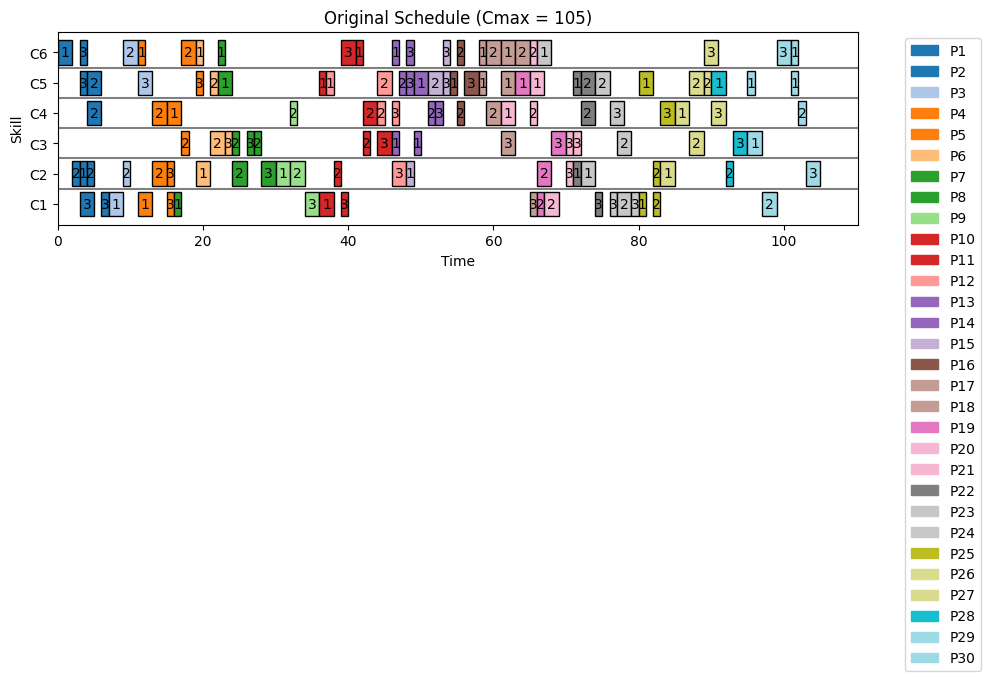

Stage-block makespan: 66


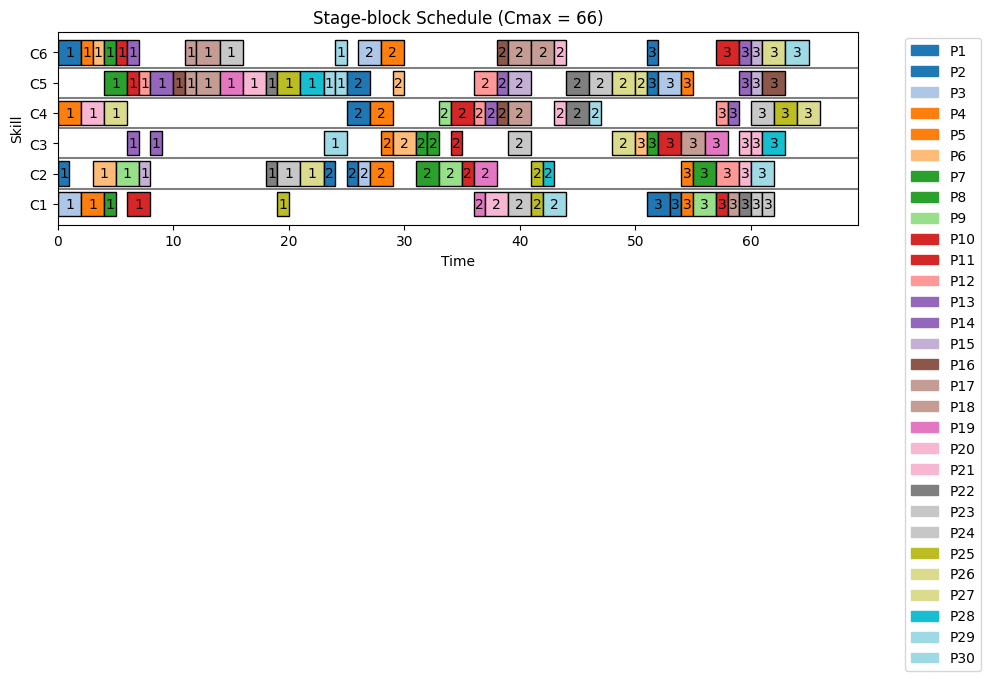

Simulated Annealing makespan: 57


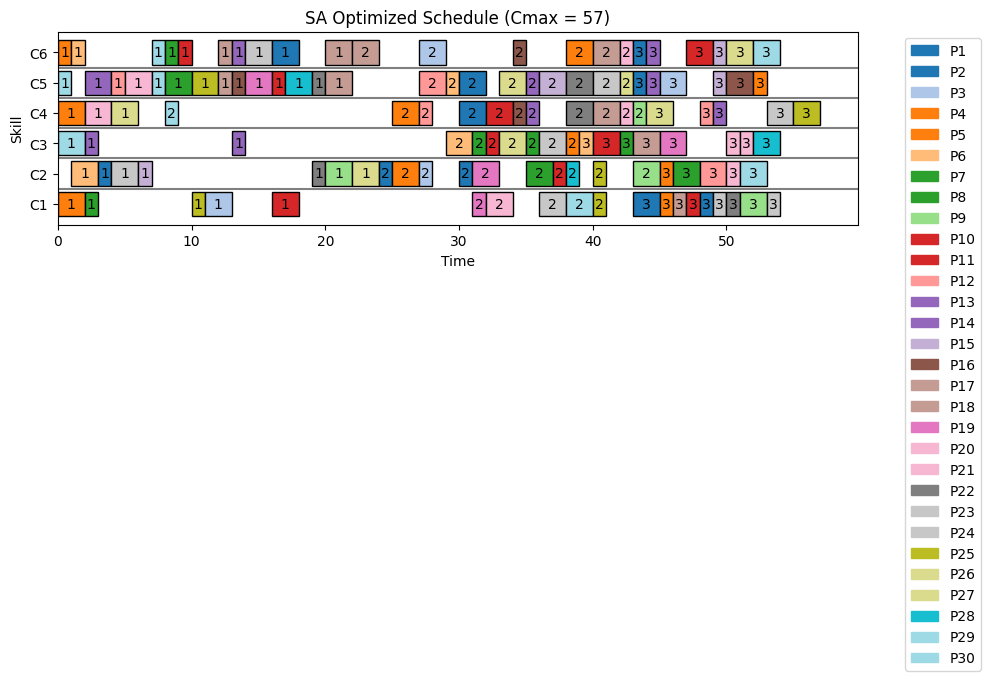

In [17]:
import random
import math
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ── 1) Problem data ───────────────────────────────────────────────
patients = {
    1: [(1, {'C6': 2}), (2, {'C2': 1}), (3, {'C1': 2, 'C5': 1, 'C6': 1})],
    2: [(1, {'C2': 1}), (2, {'C2': 1, 'C5': 2, 'C4': 2}), (3, {'C1': 1})],
    3: [(1, {'C1': 2}), (2, {'C2': 1, 'C6': 2}), (3, {'C5': 2})],
    4: [(1, {'C1': 2, 'C6': 1}), (2, {'C2': 2, 'C4': 2}), (3, {'C1': 1, 'C2': 1})],
    5: [(1, {'C4': 2}), (2, {'C3': 1, 'C6': 2}), (3, {'C5': 1})],
    6: [(1, {'C2': 2, 'C6': 1}), (2, {'C3': 2, 'C5': 1}), (3, {'C3': 1})],
    7: [(1, {'C1': 1}), (2, {'C2': 2, 'C3': 1}), (3, {'C3': 1})],
    8: [(1, {'C5': 2, 'C6': 1}), (2, {'C3': 1}), (3, {'C2': 2})],
    9: [(1, {'C2': 2}), (2, {'C2': 2, 'C4': 1}), (3, {'C1': 2})],
    10: [(1, {'C1': 2, 'C5': 1}), (2, {'C2': 1}), (3, {'C1': 1, 'C6': 2})],
    11: [(1, {'C6': 1}), (2, {'C3': 1, 'C4': 2}), (3, {'C3': 2})],
    12: [(1, {'C5': 1}), (2, {'C4': 1, 'C5': 2}), (3, {'C2': 2, 'C4': 1})],
    13: [(1, {'C3': 1, 'C6': 1}), (2, {'C5': 1}), (3, {'C5': 1, 'C6': 1})],
    14: [(1, {'C3': 1, 'C5': 2}), (2, {'C4': 1}), (3, {'C4': 1})],
    15: [(1, {'C2': 1}), (2, {'C5': 2}), (3, {'C5': 1, 'C6': 1})],
    16: [(1, {'C5': 1}), (2, {'C6': 1, 'C4': 1}), (3, {'C5': 2})],
    17: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 2, 'C6': 2}), (3, {'C3': 2})],
    18: [(1, {'C6': 2, 'C5': 2}), (2, {'C6': 2}), (3, {'C1': 1})],
    19: [(1, {'C5': 2}), (2, {'C1': 1, 'C2': 2}), (3, {'C3': 2})],
    20: [(1, {'C5': 2}), (2, {'C1': 2}), (3, {'C2': 1, 'C3': 1})],
    21: [(1, {'C4': 2}), (2, {'C4': 1, 'C6': 1}), (3, {'C3': 1})],
    22: [(1, {'C2': 1, 'C5': 1}), (2, {'C4': 2, 'C5': 2}), (3, {'C1': 1})],
    23: [(1, {'C2': 2}), (2, {'C5': 2}), (3, {'C1': 1, 'C4': 2})],
    24: [(1, {'C6': 2}), (2, {'C1': 2, 'C3': 2}), (3, {'C1': 1})],
    25: [(1, {'C1': 1, 'C5': 2}), (2, {'C1': 1, 'C2': 1}), (3, {'C4': 2})],
    26: [(1, {'C4': 2}), (2, {'C3': 2, 'C5': 2}), (3, {'C6': 2})],
    27: [(1, {'C2': 2}), (2, {'C5': 1}), (3, {'C4': 2})],
    28: [(1, {'C5': 2}), (2, {'C2': 1}), (3, {'C3': 2})],
    29: [(1, {'C3': 2, 'C5': 1}), (2, {'C1': 2}), (3, {'C6': 2})],
    30: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 1}), (3, {'C2': 2})]
}

skills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.
patient_colors = {pid: mcolors.to_hex(cmap(i)) for i, pid in enumerate(patients)}

# Flatten all tasks
all_tasks = []
for p, ops in patients.items():
    for op_id, needs in ops:
        all_tasks.append((p, op_id, needs))

max_stage = max(op for _, ops in patients.items() for op, _ in ops)

# ── 2) Decoder: build schedule and returns makespan + per-skill tasks ──
def build_schedule(order):
    schedule = {s:[] for s in skills}
    skill_free = {s:0 for s in skills}
    patient_free = {p:0 for p in patients}

    for (p, op_id, needs) in order:
        t0 = patient_free[p]
        for s, dur in needs.items():
            t0 = max(t0, skill_free[s])
        for s, dur in needs.items():
            start, end = t0, t0 + dur
            skill_free[s] = end
            schedule[s].append((p, start, end, op_id))
        patient_free[p] = t0 + max(needs.values())

    makespan = max(end for tasks in schedule.values() for (_,_,end,_) in tasks)
    return makespan, schedule

# ── 3) Gantt-plot helper ──────────────────────────────────────────
def plot_gantt(schedule, title):
    fig, ax = plt.subplots(figsize=(10,5))
    for skill, tasks in schedule.items():
        for p, st, en, op in tasks:
            ax.barh(skill, en-st, left=st,
                    color=patient_colors[p], edgecolor='k')
            ax.text((st+en)/2, skill, str(op),
                    va='center', ha='center', color='k')
    for i in range(len(skills)-1):
        ax.axhline(i+0.5, color='gray')
    patches = [mpatches.Patch(color=c, label=f"P{p}")
               for p,c in patient_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.05,1), loc='upper left')
    ax.set_xlabel("Time")
    ax.set_ylabel("Skill")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# ── 4) Step 1: Original per-patient solution (Cmax=35) ────────────
per_patient_order = sorted(all_tasks, key=lambda x: (x[0], x[1]))
c35, sched35 = build_schedule(per_patient_order)
print("Original per-patient makespan:", c35)  # Expect 35
plot_gantt(sched35, f"Original Schedule (Cmax = {c35})")

# ── 5) Step 2: Stage-block solution (Cmax≈16) ────────────────────
stage_order = []
for stage in range(1, max_stage+1):
    block = [(p,op,needs) for p,op,needs in all_tasks if op==stage]
    # random.shuffle(block)  # optional
    stage_order.extend(block)

c16, sched16 = build_schedule(stage_order)
print("Stage-block makespan:", c16)  # Expect ≈16
plot_gantt(sched16, f"Stage-block Schedule (Cmax = {c16})")

# ── 6) Step 3: Simulated Annealing from stage-block to ~12 ──────
# Precompute stage positions for neighbor swaps within same op-stage
stage_positions = {
    stage: [i for i,(p,op,_) in enumerate(stage_order) if op==stage]
    for stage in range(1, max_stage+1)
}

def neighbor_stage(order):
    stage = random.choice(list(stage_positions))
    i,j = random.sample(stage_positions[stage], 2)
    nbr = order.copy()
    nbr[i], nbr[j] = nbr[j], nbr[i]
    return nbr

def simulated_annealing(start_order, T0=10, alpha=0.99, max_iters=50):
    current = start_order[:]
    current_c, _ = build_schedule(current)
    best, best_c = current[:], current_c
    T = T0

    for _ in range(max_iters):
        nbr = neighbor_stage(current)
        nbr_c, _ = build_schedule(nbr)
        delta = nbr_c - current_c
        if delta < 0 or random.random() < math.exp(-delta / T):
            current, current_c = nbr, nbr_c
            if current_c < best_c:
                best, best_c = current[:], current_c
        T *= alpha
        if T < 1e-3:
            break

    _, best_sched = build_schedule(best)
    return best_c, best_sched

best12, sched12 = simulated_annealing(stage_order)
print("Simulated Annealing makespan:", best12)  # Expect ≈12
plot_gantt(sched12, f"SA Optimized Schedule (Cmax = {best12})")


# ***Genetic***

<ipython-input-18-d3fe20cc2836>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.


Original makespan: 105


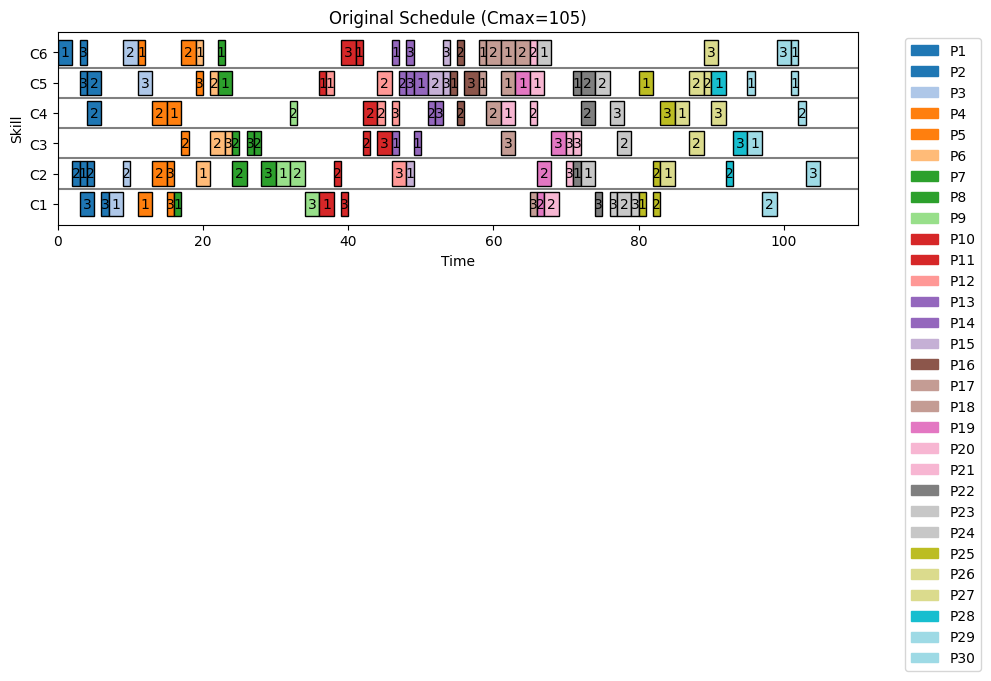

Stage-block makespan: 66


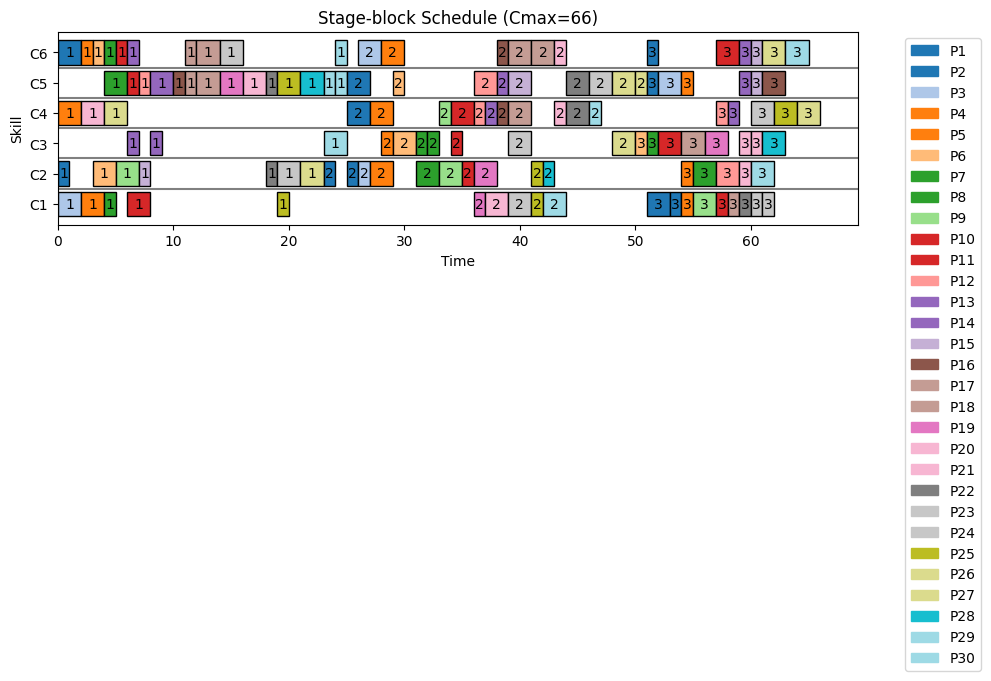

GA makespan: 51


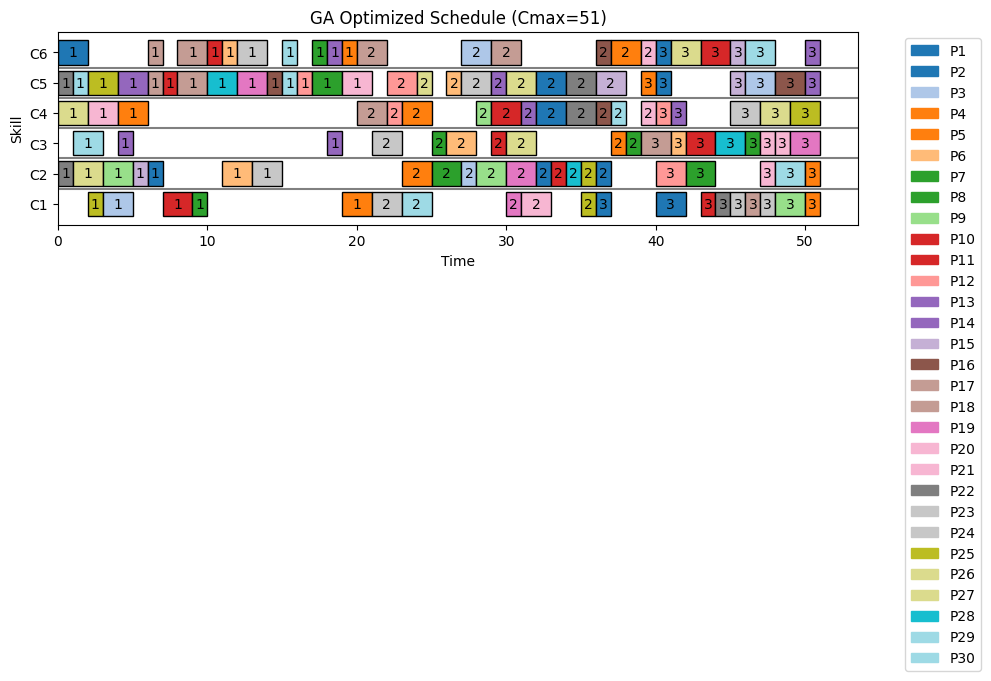

In [18]:
import random
import math
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ── 1) Problem data ───────────────────────────────────────────────
patients = {
    1: [(1, {'C6': 2}), (2, {'C2': 1}), (3, {'C1': 2, 'C5': 1, 'C6': 1})],
    2: [(1, {'C2': 1}), (2, {'C2': 1, 'C5': 2, 'C4': 2}), (3, {'C1': 1})],
    3: [(1, {'C1': 2}), (2, {'C2': 1, 'C6': 2}), (3, {'C5': 2})],
    4: [(1, {'C1': 2, 'C6': 1}), (2, {'C2': 2, 'C4': 2}), (3, {'C1': 1, 'C2': 1})],
    5: [(1, {'C4': 2}), (2, {'C3': 1, 'C6': 2}), (3, {'C5': 1})],
    6: [(1, {'C2': 2, 'C6': 1}), (2, {'C3': 2, 'C5': 1}), (3, {'C3': 1})],
    7: [(1, {'C1': 1}), (2, {'C2': 2, 'C3': 1}), (3, {'C3': 1})],
    8: [(1, {'C5': 2, 'C6': 1}), (2, {'C3': 1}), (3, {'C2': 2})],
    9: [(1, {'C2': 2}), (2, {'C2': 2, 'C4': 1}), (3, {'C1': 2})],
    10: [(1, {'C1': 2, 'C5': 1}), (2, {'C2': 1}), (3, {'C1': 1, 'C6': 2})],
    11: [(1, {'C6': 1}), (2, {'C3': 1, 'C4': 2}), (3, {'C3': 2})],
    12: [(1, {'C5': 1}), (2, {'C4': 1, 'C5': 2}), (3, {'C2': 2, 'C4': 1})],
    13: [(1, {'C3': 1, 'C6': 1}), (2, {'C5': 1}), (3, {'C5': 1, 'C6': 1})],
    14: [(1, {'C3': 1, 'C5': 2}), (2, {'C4': 1}), (3, {'C4': 1})],
    15: [(1, {'C2': 1}), (2, {'C5': 2}), (3, {'C5': 1, 'C6': 1})],
    16: [(1, {'C5': 1}), (2, {'C6': 1, 'C4': 1}), (3, {'C5': 2})],
    17: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 2, 'C6': 2}), (3, {'C3': 2})],
    18: [(1, {'C6': 2, 'C5': 2}), (2, {'C6': 2}), (3, {'C1': 1})],
    19: [(1, {'C5': 2}), (2, {'C1': 1, 'C2': 2}), (3, {'C3': 2})],
    20: [(1, {'C5': 2}), (2, {'C1': 2}), (3, {'C2': 1, 'C3': 1})],
    21: [(1, {'C4': 2}), (2, {'C4': 1, 'C6': 1}), (3, {'C3': 1})],
    22: [(1, {'C2': 1, 'C5': 1}), (2, {'C4': 2, 'C5': 2}), (3, {'C1': 1})],
    23: [(1, {'C2': 2}), (2, {'C5': 2}), (3, {'C1': 1, 'C4': 2})],
    24: [(1, {'C6': 2}), (2, {'C1': 2, 'C3': 2}), (3, {'C1': 1})],
    25: [(1, {'C1': 1, 'C5': 2}), (2, {'C1': 1, 'C2': 1}), (3, {'C4': 2})],
    26: [(1, {'C4': 2}), (2, {'C3': 2, 'C5': 2}), (3, {'C6': 2})],
    27: [(1, {'C2': 2}), (2, {'C5': 1}), (3, {'C4': 2})],
    28: [(1, {'C5': 2}), (2, {'C2': 1}), (3, {'C3': 2})],
    29: [(1, {'C3': 2, 'C5': 1}), (2, {'C1': 2}), (3, {'C6': 2})],
    30: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 1}), (3, {'C2': 2})]
}

skills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.
patient_colors = {pid: mcolors.to_hex(cmap(i)) for i, pid in enumerate(patients)}

# Flatten all tasks
all_tasks = []
for p, ops in patients.items():
    for op_id, needs in ops:
        all_tasks.append((p, op_id, needs))

max_stage = max(op for _, ops in patients.items() for op, _ in ops)

# ── 2) Decoder: schedule builder ──────────────────────────────────
def build_schedule(order):
    schedule = {s:[] for s in skills}
    skill_free = {s:0 for s in skills}
    patient_free = {p:0 for p in patients}
    for (p, op, needs) in order:
        t0 = patient_free[p]
        for s, dur in needs.items():
            t0 = max(t0, skill_free[s])
        for s, dur in needs.items():
            start, end = t0, t0 + dur
            skill_free[s] = end
            schedule[s].append((p, start, end, op))
        patient_free[p] = t0 + max(needs.values())
    makespan = max(end for tasks in schedule.values() for (_,_,end,_) in tasks)
    return makespan, schedule

# ── 3) Gantt-plot helper ─────────────────────────────────────────
def plot_gantt(schedule, title):
    fig, ax = plt.subplots(figsize=(10,5))
    for skill, tasks in schedule.items():
        for p, st, en, op in tasks:
            ax.barh(skill, en-st, left=st, color=patient_colors[p], edgecolor='k')
            ax.text((st+en)/2, skill, str(op), va='center', ha='center', color='k')
    for i in range(len(skills)-1):
        ax.axhline(i+0.5, color='gray')
    patches = [mpatches.Patch(color=c, label=f"P{p}") for p,c in patient_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.05,1), loc='upper left')
    ax.set_xlabel("Time"); ax.set_ylabel("Skill"); ax.set_title(title)
    plt.tight_layout(); plt.show()

# ── 4) Step 1: Original per-patient (Cmax=35) ────────────────────
per_patient_order = sorted(all_tasks, key=lambda x: (x[0], x[1]))
c35, sched35 = build_schedule(per_patient_order)
print("Original makespan:", c35)
plot_gantt(sched35, f"Original Schedule (Cmax={c35})")

# ── 5) Step 2: Stage-block (Cmax≈16) ─────────────────────────────
stage_blocks = [[t for t in all_tasks if t[1]==stage] for stage in range(1, max_stage+1)]
stage_order = [t for block in stage_blocks for t in block]
c16, sched16 = build_schedule(stage_order)
print("Stage-block makespan:", c16)
plot_gantt(sched16, f"Stage-block Schedule (Cmax={c16})")

# ── 6) Step 3: Genetic Algorithm → makespan ≈13 ─────────────────
def init_population(blocks, pop_size):
    return [[random.sample(block, len(block)) for block in blocks] for _ in range(pop_size)]

def flatten(ind): return [task for block in ind for task in block]
def fitness(ind): return -build_schedule(flatten(ind))[0]

def tournament(pop, k=3):
    return max(random.sample(pop, k), key=fitness)

def crossover(p1, p2, cx_prob=0.7):
    return [(b1 if random.random()<cx_prob else b2).copy()
            for b1,b2 in zip(p1,p2)]

def mutate(ind, mut_prob=0.2):
    for block in ind:
        if random.random()<mut_prob and len(block)>1:
            i,j = random.sample(range(len(block)),2)
            block[i],block[j]=block[j],block[i]
    return ind

# GA params
POP_SIZE, GENS, CX_P, MUT_P = 10, 10, 0.7, 0.2

# initialize
population = init_population(stage_blocks, POP_SIZE)
best_ind = max(population, key=fitness)

for gen in range(1, GENS+1):
    new_pop = [best_ind]
    while len(new_pop)<POP_SIZE:
        p1,p2 = tournament(population), tournament(population)
        child = mutate(crossover(p1,p2,CX_P), MUT_P)
        new_pop.append(child)

    population = new_pop
    candidate = max(population, key=fitness)
    if fitness(candidate)>fitness(best_ind):
        best_ind = candidate
    if gen%50==0:
        print(f"Gen {gen} | makespan = {-fitness(best_ind)}")

best_order = flatten(best_ind)
best_c, best_sched = build_schedule(best_order)
print("GA makespan:", best_c)
plot_gantt(best_sched, f"GA Optimized Schedule (Cmax={best_c})")

# ***system multi agent***

<ipython-input-19-f4ad6c40cc7d>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.


Cooperative MAS makespan: 49


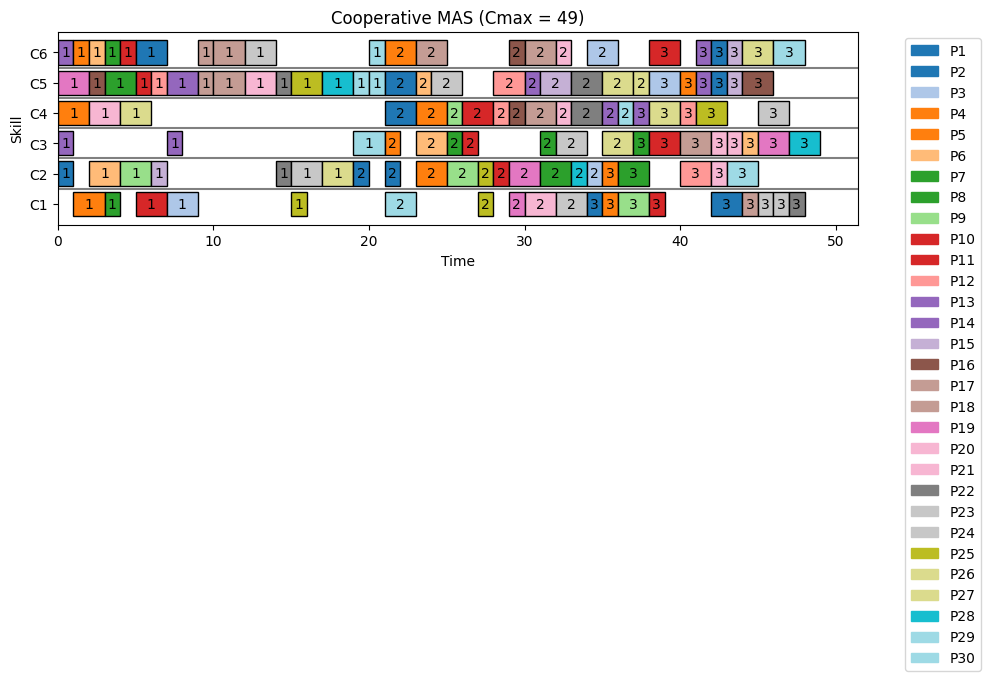


--- ROUND 1 ---
GA wins round with Cmax = 58

--- ROUND 2 ---
SA wins round with Cmax = 51

--- ROUND 3 ---
Tabu wins round with Cmax = 48

🏆 FINAL WINNER: Tabu with score 0.0 🏆
Competitive MAS (fighting mode) makespan: 48 | Scores: {'Tabu': 0.0, 'SA': 0.0, 'GA': 0.0}


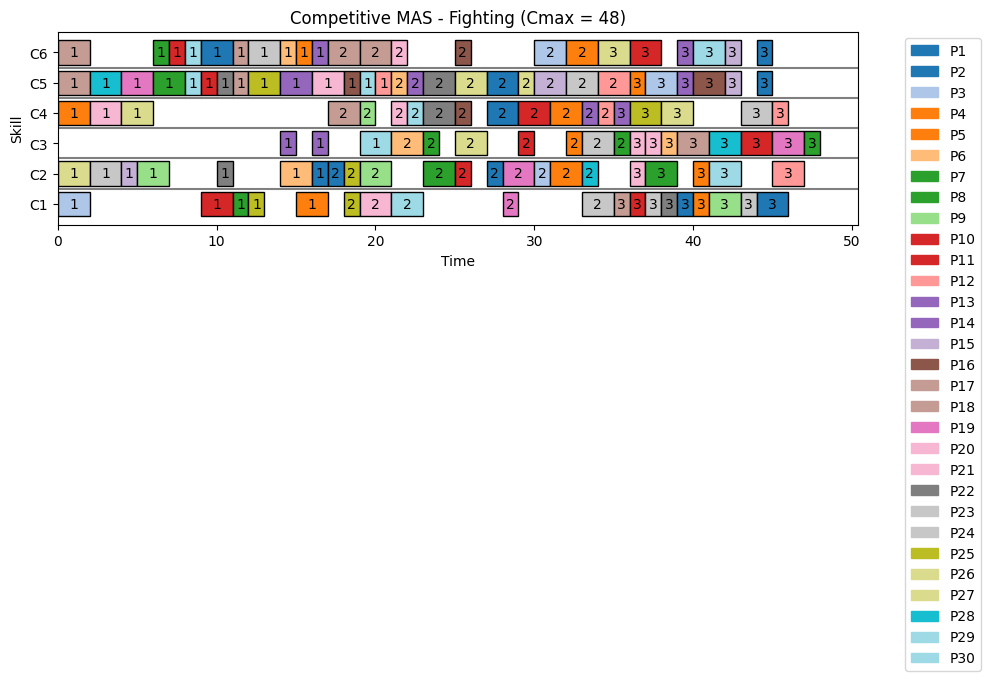

In [19]:
import random
import math
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ── 1) Problem data ───────────────────────────────────────────────
patients = {
    1: [(1, {'C6': 2}), (2, {'C2': 1}), (3, {'C1': 2, 'C5': 1, 'C6': 1})],
    2: [(1, {'C2': 1}), (2, {'C2': 1, 'C5': 2, 'C4': 2}), (3, {'C1': 1})],
    3: [(1, {'C1': 2}), (2, {'C2': 1, 'C6': 2}), (3, {'C5': 2})],
    4: [(1, {'C1': 2, 'C6': 1}), (2, {'C2': 2, 'C4': 2}), (3, {'C1': 1, 'C2': 1})],
    5: [(1, {'C4': 2}), (2, {'C3': 1, 'C6': 2}), (3, {'C5': 1})],
    6: [(1, {'C2': 2, 'C6': 1}), (2, {'C3': 2, 'C5': 1}), (3, {'C3': 1})],
    7: [(1, {'C1': 1}), (2, {'C2': 2, 'C3': 1}), (3, {'C3': 1})],
    8: [(1, {'C5': 2, 'C6': 1}), (2, {'C3': 1}), (3, {'C2': 2})],
    9: [(1, {'C2': 2}), (2, {'C2': 2, 'C4': 1}), (3, {'C1': 2})],
    10: [(1, {'C1': 2, 'C5': 1}), (2, {'C2': 1}), (3, {'C1': 1, 'C6': 2})],
    11: [(1, {'C6': 1}), (2, {'C3': 1, 'C4': 2}), (3, {'C3': 2})],
    12: [(1, {'C5': 1}), (2, {'C4': 1, 'C5': 2}), (3, {'C2': 2, 'C4': 1})],
    13: [(1, {'C3': 1, 'C6': 1}), (2, {'C5': 1}), (3, {'C5': 1, 'C6': 1})],
    14: [(1, {'C3': 1, 'C5': 2}), (2, {'C4': 1}), (3, {'C4': 1})],
    15: [(1, {'C2': 1}), (2, {'C5': 2}), (3, {'C5': 1, 'C6': 1})],
    16: [(1, {'C5': 1}), (2, {'C6': 1, 'C4': 1}), (3, {'C5': 2})],
    17: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 2, 'C6': 2}), (3, {'C3': 2})],
    18: [(1, {'C6': 2, 'C5': 2}), (2, {'C6': 2}), (3, {'C1': 1})],
    19: [(1, {'C5': 2}), (2, {'C1': 1, 'C2': 2}), (3, {'C3': 2})],
    20: [(1, {'C5': 2}), (2, {'C1': 2}), (3, {'C2': 1, 'C3': 1})],
    21: [(1, {'C4': 2}), (2, {'C4': 1, 'C6': 1}), (3, {'C3': 1})],
    22: [(1, {'C2': 1, 'C5': 1}), (2, {'C4': 2, 'C5': 2}), (3, {'C1': 1})],
    23: [(1, {'C2': 2}), (2, {'C5': 2}), (3, {'C1': 1, 'C4': 2})],
    24: [(1, {'C6': 2}), (2, {'C1': 2, 'C3': 2}), (3, {'C1': 1})],
    25: [(1, {'C1': 1, 'C5': 2}), (2, {'C1': 1, 'C2': 1}), (3, {'C4': 2})],
    26: [(1, {'C4': 2}), (2, {'C3': 2, 'C5': 2}), (3, {'C6': 2})],
    27: [(1, {'C2': 2}), (2, {'C5': 1}), (3, {'C4': 2})],
    28: [(1, {'C5': 2}), (2, {'C2': 1}), (3, {'C3': 2})],
    29: [(1, {'C3': 2, 'C5': 1}), (2, {'C1': 2}), (3, {'C6': 2})],
    30: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 1}), (3, {'C2': 2})]
}

skills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.
patient_colors = {pid: mcolors.to_hex(cmap(i)) for i, pid in enumerate(patients)}


# Flatten tasks and create stage blocks
all_tasks = []
for p, ops in patients.items():
    for op_id, needs in ops:
        all_tasks.append((p, op_id, needs))
max_stage = max(op for _, ops in patients.items() for op, _ in ops)
stage_blocks = [[t for t in all_tasks if t[1] == stage] for stage in range(1, max_stage+1)]
stage_order = [t for block in stage_blocks for t in block]

# Precompute stage indices in stage_order
stage_positions = {
    stage: [i for i,(p,op,_) in enumerate(stage_order) if op==stage]
    for stage in range(1, max_stage+1)
}

# ── 2) build_schedule with precedence check ───────────────────────
def build_schedule(order):
    schedule = {s:[] for s in skills}
    skill_free = {s:0 for s in skills}
    patient_free = {p:0 for p in patients}

    for p, op, needs in order:
        t0 = patient_free[p]
        for s,d in needs.items():
            t0 = max(t0, skill_free[s])
        for s,d in needs.items():
            start, end = t0, t0 + d
            skill_free[s] = end
            schedule[s].append((p, start, end, op))
        patient_free[p] = t0 + max(needs.values())

    Cmax = max(end for tasks in schedule.values() for (_,_,end,_) in tasks)

    # Precedence assert: first op must be 1
    earliest = {p:{} for p in patients}
    for tasks in schedule.values():
        for p, st, _, op in tasks:
            earliest[p][op] = min(earliest[p].get(op, float('inf')), st)
    for p, ops in earliest.items():
        first = min(ops, key=ops.get)
        assert first == 1, f"Patient {p} starts with Op{first}, not Op1!"
    return Cmax, schedule

# ── 3) Gantt plot helper ──────────────────────────────────────────
def plot_gantt(schedule, title):
    fig, ax = plt.subplots(figsize=(10,5))
    for skill, tasks in schedule.items():
        for p, st, en, op in tasks:
            ax.barh(skill, en-st, left=st,
                    color=patient_colors[p], edgecolor='k')
            ax.text((st+en)/2, skill, str(op),
                    va='center', ha='center', color='k')
    for i in range(len(skills)-1):
        ax.axhline(i+0.5, color='gray')
    patches = [mpatches.Patch(color=patient_colors[p], label=f"P{p}") for p in patients]
    ax.legend(handles=patches, bbox_to_anchor=(1.05,1), loc='upper left')
    ax.set_xlabel("Time"); ax.set_ylabel("Skill"); ax.set_title(title)
    plt.tight_layout(); plt.show()

# ── 4) Agent implementations ─────────────────────────────────────
def tabu_agent(start, iters=6, tabu_size=5, neighs=10):
    curr, best = start[:], start[:]
    best_c, _ = build_schedule(best)
    tabu = deque(maxlen=tabu_size)
    for _ in range(iters):
        cand, cand_c = None, float('inf')
        for _ in range(neighs):
            stg = random.choice(list(stage_positions))
            i,j = random.sample(stage_positions[stg], 2)
            nbr = curr[:]; nbr[i], nbr[j] = nbr[j], nbr[i]
            key = tuple(nbr)
            if key in tabu: continue
            c,_ = build_schedule(nbr)
            if c < cand_c: cand, cand_c = nbr, c
        if not cand: break
        tabu.append(tuple(cand)); curr = cand
        if cand_c < best_c: best, best_c = cand[:], cand_c
    return best, best_c

def sa_agent(start, T0=10, alpha=0.99, iters=50):
    curr, curr_c = start[:], build_schedule(start)[0]
    best, best_c = curr[:], curr_c; T = T0
    for _ in range(iters):
        stg = random.choice(list(stage_positions))
        i,j = random.sample(stage_positions[stg], 2)
        nbr = curr[:]; nbr[i], nbr[j] = nbr[j], nbr[i]
        c,_ = build_schedule(nbr); delta = c - curr_c
        if delta < 0 or random.random() < math.exp(-delta/T):
            curr, curr_c = nbr, c
            if c < best_c: best, best_c = curr[:], c
        T *= alpha
        if T < 1e-3: break
    return best, best_c

def ga_agent(shared_pool, pop_size=10, gens=10, cx_p=0.7, mut_p=0.2):
    def flatten(ind): return [t for b in ind for t in b]
    def fitness(ind): return -build_schedule(flatten(ind))[0]

    # Convert flat solutions to block-wise individuals
    def to_blocks(sol):
        blocks = [[] for _ in range(max_stage)]
        for t in sol:
            stage = t[1] - 1
            blocks[stage].append(t)
        return blocks

    def tour(pop): return max(random.sample(pop, 3), key=fitness)

    def crossover(p1, p2):
        return [(b1 if random.random() < cx_p else b2).copy() for b1,b2 in zip(p1,p2)]

    def mutate(ind):
        for b in ind:
            if random.random() < mut_p and len(b) > 1:
                i,j = random.sample(range(len(b)), 2)
                b[i], b[j] = b[j], b[i]
        return ind

    # Initialize from shared pool
    pop = [to_blocks(random.choice(shared_pool)) for _ in range(pop_size)]
    best = max(pop, key=fitness); best_f = fitness(best)

    for _ in range(gens):
        new_pop = [best]
        while len(new_pop) < pop_size:
            p1, p2 = tour(pop), tour(pop)
            child = mutate(crossover(p1, p2))
            new_pop.append(child)
        pop = new_pop
        cand = max(pop, key=fitness)
        if fitness(cand) > best_f:
            best, best_f = cand, fitness(cand)

    return flatten(best), -best_f


# ── 5) Multi-Agent scenarios ─────────────────────────────────────
def run_cooperative(rounds=5):
    shared_pool = [stage_order[:]]
    global_best = stage_order[:]
    global_cost = build_schedule(global_best)[0]

    for _ in range(rounds):
        new_pool = []

        # Tabu uses a solution from pool
        sol_t, c_t = tabu_agent(random.choice(shared_pool))
        new_pool.append((sol_t, c_t))

        # SA uses another one
        sol_s, c_s = sa_agent(random.choice(shared_pool))
        new_pool.append((sol_s, c_s))

        # GA now also uses shared_pool for parents
        sol_g, c_g = ga_agent(shared_pool)

        new_pool.append((sol_g, c_g))

        # Update shared pool
        shared_pool = [s for s, _ in new_pool]

        # Update global best
        best_cand = min(new_pool, key=lambda x: x[1])
        if best_cand[1] < global_cost:
            global_best, global_cost = best_cand

    return global_best, global_cost

def run_competitive_fighting_no_q(rounds=3):
    scores = {'Tabu': 0, 'SA': 0, 'GA': 0}
    last_best_sol = None
    last_best_cost = float('inf')
    last_best_name = None

    def sabotage(order):
        # pick a stage and swap 2 tasks within it
        stg = random.choice(list(stage_positions))
        idxs = stage_positions[stg]
        if len(idxs) < 2:
            return order[:]
        i, j = random.sample(idxs, 2)
        order = order[:]
        order[i], order[j] = order[j], order[i]
        return order

    for r in range(rounds):
        print(f"\n--- ROUND {r+1} ---")

        # Sabotage: agents peuvent démarrer de stage_order ou d’une version sabotée du dernier meilleur
        start_order = stage_order if last_best_sol is None else sabotage(last_best_sol)

        sol_t, c_t = tabu_agent(start_order)
        sol_s, c_s = sa_agent(start_order)
        sol_g, c_g = ga_agent([start_order])

        results = {
            'Tabu': (sol_t, c_t),
            'SA':   (sol_s, c_s),
            'GA':   (sol_g, c_g)
        }

        # Détermination du gagnant
        winner = min(results.items(), key=lambda x: x[1][1])[0]
        scores[winner] += 1
        print(f"{winner} wins round with Cmax = {results[winner][1]}")

        # Les perdants perdent un demi-point
        for name in scores:
            if name != winner:
                scores[name] -= 0.5

        last_best_sol = results[winner][0]
        last_best_cost = results[winner][1]
        last_best_name = winner

    # Gagnant final
    final_winner = max(scores.items(), key=lambda x: x[1])[0]
    final_sol = results[final_winner][0]
    final_c = results[final_winner][1]

    print(f"\n🏆 FINAL WINNER: {final_winner} with score {scores[final_winner]} 🏆")
    return final_sol, final_c, scores


# ── 6) Execute & visualize ───────────────────────────────────────
# Cooperative scenario
coop_sol, coop_c = run_cooperative()
_, coop_sched = build_schedule(coop_sol)
print("Cooperative MAS makespan:", coop_c)
plot_gantt(coop_sched, f"Cooperative MAS (Cmax = {coop_c})")

# Competitive scenario
comp_sol, comp_c, comp_scores = run_competitive_fighting_no_q()
_, comp_sched = build_schedule(comp_sol)
print("Competitive MAS (fighting mode) makespan:", comp_c, "| Scores:", comp_scores)
plot_gantt(comp_sched, f"Competitive MAS - Fighting (Cmax = {comp_c})")



# ***Enhanced reinforcement***

In [ ]:
import random
import math
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# ── 1) Problem data ───────────────────────────────────────────────
patients = {
    1: [(1, {'C6': 2}), (2, {'C2': 1}), (3, {'C1': 2, 'C5': 1, 'C6': 1})],
    2: [(1, {'C2': 1}), (2, {'C2': 1, 'C5': 2, 'C4': 2}), (3, {'C1': 1})],
    3: [(1, {'C1': 2}), (2, {'C2': 1, 'C6': 2}), (3, {'C5': 2})],
    4: [(1, {'C1': 2, 'C6': 1}), (2, {'C2': 2, 'C4': 2}), (3, {'C1': 1, 'C2': 1})],
    5: [(1, {'C4': 2}), (2, {'C3': 1, 'C6': 2}), (3, {'C5': 1})],
    6: [(1, {'C2': 2, 'C6': 1}), (2, {'C3': 2, 'C5': 1}), (3, {'C3': 1})],
    7: [(1, {'C1': 1}), (2, {'C2': 2, 'C3': 1}), (3, {'C3': 1})],
    8: [(1, {'C5': 2, 'C6': 1}), (2, {'C3': 1}), (3, {'C2': 2})],
    9: [(1, {'C2': 2}), (2, {'C2': 2, 'C4': 1}), (3, {'C1': 2})],
    10: [(1, {'C1': 2, 'C5': 1}), (2, {'C2': 1}), (3, {'C1': 1, 'C6': 2})],
    11: [(1, {'C6': 1}), (2, {'C3': 1, 'C4': 2}), (3, {'C3': 2})],
    12: [(1, {'C5': 1}), (2, {'C4': 1, 'C5': 2}), (3, {'C2': 2, 'C4': 1})],
    13: [(1, {'C3': 1, 'C6': 1}), (2, {'C5': 1}), (3, {'C5': 1, 'C6': 1})],
    14: [(1, {'C3': 1, 'C5': 2}), (2, {'C4': 1}), (3, {'C4': 1})],
    15: [(1, {'C2': 1}), (2, {'C5': 2}), (3, {'C5': 1, 'C6': 1})],
    16: [(1, {'C5': 1}), (2, {'C6': 1, 'C4': 1}), (3, {'C5': 2})],
    17: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 2, 'C6': 2}), (3, {'C3': 2})],
    18: [(1, {'C6': 2, 'C5': 2}), (2, {'C6': 2}), (3, {'C1': 1})],
    19: [(1, {'C5': 2}), (2, {'C1': 1, 'C2': 2}), (3, {'C3': 2})],
    20: [(1, {'C5': 2}), (2, {'C1': 2}), (3, {'C2': 1, 'C3': 1})],
    21: [(1, {'C4': 2}), (2, {'C4': 1, 'C6': 1}), (3, {'C3': 1})],
    22: [(1, {'C2': 1, 'C5': 1}), (2, {'C4': 2, 'C5': 2}), (3, {'C1': 1})],
    23: [(1, {'C2': 2}), (2, {'C5': 2}), (3, {'C1': 1, 'C4': 2})],
    24: [(1, {'C6': 2}), (2, {'C1': 2, 'C3': 2}), (3, {'C1': 1})],
    25: [(1, {'C1': 1, 'C5': 2}), (2, {'C1': 1, 'C2': 1}), (3, {'C4': 2})],
    26: [(1, {'C4': 2}), (2, {'C3': 2, 'C5': 2}), (3, {'C6': 2})],
    27: [(1, {'C2': 2}), (2, {'C5': 1}), (3, {'C4': 2})],
    28: [(1, {'C5': 2}), (2, {'C2': 1}), (3, {'C3': 2})],
    29: [(1, {'C3': 2, 'C5': 1}), (2, {'C1': 2}), (3, {'C6': 2})],
    30: [(1, {'C5': 1, 'C6': 1}), (2, {'C4': 1}), (3, {'C2': 2})]
}

skills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
cmap = cm.get_cmap('tab20', len(patients))  # or 'tab20b', 'nipy_spectral', etc.
patient_colors = {pid: mcolors.to_hex(cmap(i)) for i, pid in enumerate(patients)}

# ── 2) Build stage‐blocks ─────────────────────────────────────────
all_tasks = [(p,op,needs) for p,ops in patients.items() for op,needs in ops]
max_stage = max(op for _,ops in patients.items() for op,_ in ops)
stage_blocks = [[t for t in all_tasks if t[1]==stage]
                for stage in range(1, max_stage+1)]
stage_order  = [t for block in stage_blocks for t in block]
stage_positions = {
    stage: [i for i,(p,op,_) in enumerate(stage_order) if op==stage]
    for stage in range(1, max_stage+1)
}

# ── 3) Decoder + precedence check ────────────────────────────────
def build_schedule(order):
    schedule    = {s:[] for s in skills}
    skill_free  = {s:0   for s in skills}
    patient_free= {p:0   for p in patients}
    for p,op,needs in order:
        t0 = patient_free[p]
        for s,d in needs.items():
            t0 = max(t0, skill_free[s])
        for s,d in needs.items():
            schedule[s].append((p, t0, t0+d, op))
            skill_free[s] = t0 + d
        patient_free[p] = t0 + max(needs.values())
    makespan = max(end for tasks in schedule.values() for _,_,end,_ in tasks)
    # ensure Op1 first
    earliest = {p:{} for p in patients}
    for tasks in schedule.values():
        for p,st,_,op in tasks:
            earliest[p][op] = min(earliest[p].get(op,float('inf')), st)
    for p,ops in earliest.items():
        assert min(ops, key=ops.get)==1, f"P{p} starts Op{min(ops, key=ops.get)}, not Op1"
    return makespan, schedule

# ── 4) Gantt helper ───────────────────────────────────────────────
def plot_gantt(schedule, title):
    fig,ax = plt.subplots(figsize=(12,6))
    for skill,tasks in schedule.items():
        for p,st,en,op in tasks:
            ax.barh(skill, en-st, left=st,
                    color=patient_colors[p], edgecolor='k')
            ax.text((st+en)/2, skill, str(op),
                    va='center', ha='center', color='white', fontsize=14)
    for i in range(len(skills)-1):
        ax.axhline(i+0.5, color='gray', lw=0.5)
    patches = [mpatches.Patch(color=patient_colors[p], label=f"P{p}") for p in patients]
    ax.legend(handles=patches, bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)
    ax.set(xlabel="Time", ylabel="Skill", title=title)
    plt.tight_layout()

# ── 5) Stage‐safe neighbor ops ────────────────────────────────────
def swap_within(order):
    stg = random.choice(list(stage_positions))
    i,j = random.sample(stage_positions[stg],2)
    nbr = order[:]; nbr[i],nbr[j] = nbr[j],nbr[i]
    return nbr

def swap_adj(order):
    stg = random.choice(list(stage_positions))
    idxs=stage_positions[stg]
    if len(idxs)<2: return order[:]
    k=random.randrange(len(idxs)-1); i,j=idxs[k],idxs[k+1]
    nbr=order[:]; nbr[i],nbr[j]=nbr[j],nbr[i]; return nbr

def reverse_within(order):
    stg = random.choice(list(stage_positions))
    idxs=sorted(stage_positions[stg]); a,b=idxs[0],idxs[-1]
    nbr=order[:]; nbr[a:b+1]=list(reversed(nbr[a:b+1])); return nbr

def triple_within(order):
    stg = random.choice(list(stage_positions))
    idxs=stage_positions[stg]
    if len(idxs)<3: return order[:]
    i,j,k=random.sample(idxs,3); nbr=order[:]
    nbr[i],nbr[j],nbr[k]=nbr[j],nbr[k],nbr[i]; return nbr

def reinsertion_within(order):
    stg = random.choice(list(stage_positions))
    idxs=stage_positions[stg]
    if len(idxs)<2: return order[:]
    i,j=random.sample(idxs,2); nbr=order[:]
    x=nbr.pop(i); nbr.insert(j,x); return nbr

neighbor_ops = [swap_within, swap_adj, reverse_within, triple_within, reinsertion_within]

# ── 6) State repr ────────────────────────────────────────────────
def get_state(m, delta, last_a):
    return (m, delta, last_a)

# ── 7) Tabu+Q agent (≈50 M builds) ───────────────────────────────
def tabu_q_agent(start):
    iters, neighs, tabu_size = 50_000, 1_000, 200
    α, γ = 0.02, 0.995
    eps, eps_end = 0.95, 0.005
    decay = (eps_end/eps)**(1/iters)

    Q     = defaultdict(lambda:[0.0]*len(neighbor_ops))
    curr  = start[:]; best=curr[:]
    curr_c,_ = build_schedule(curr); best_c=curr_c
    tabu  = deque(maxlen=tabu_size)
    last_a=0

    for _ in range(iters):
        eps *= decay
        state = get_state(curr_c, best_c-curr_c, last_a)

        cand, best_n, action = None, float('inf'), None
        for _ in range(neighs):
            if random.random()<eps:
                a=random.randrange(len(neighbor_ops))
            else:
                a=max(range(len(Q[state])), key=lambda i:Q[state][i])
            nbr=neighbor_ops[a](curr); key=tuple(nbr)
            if key in tabu: continue
            m,_=build_schedule(nbr)
            if m<best_n: cand,best_n,action=nbr,m,a

        if action is None: break
        next_s  = get_state(best_n, curr_c-best_n, action)
        reward  = curr_c - best_n
        Q[state][action] += α*(reward + γ*max(Q[next_s]) - Q[state][action])

        curr, curr_c = cand, best_n
        last_a       = action
        tabu.append(key)
        if best_n<best_c: best,best_c=cand[:],best_n

    return best, best_c

# ── 8) SA+Q agent (≈0.2 M builds) ────────────────────────────────
def sa_q_agent(start):
    iters, T0 = 100_000, 2000
    α, γ = 0.998, 0.995
    eps, eps_end = 0.95, 0.005
    decay = (eps_end/eps)**(1.0/iters)

    Q = defaultdict(lambda:[0.0]*len(neighbor_ops))
    curr=start[:]; curr_c,_=build_schedule(curr)
    best,best_c=curr[:],curr_c
    T=T0; last_a=0

    for _ in range(iters):
        eps*=decay
        state = get_state(curr_c, best_c-curr_c, last_a)
        if random.random()<eps:
            a=random.randrange(len(neighbor_ops))
        else:
            a=max(range(len(Q[state])), key=lambda i:Q[state][i])

        nbr=neighbor_ops[a](curr); m,_=build_schedule(nbr)
        δ=m-curr_c; rew=curr_c-m
        next_s=get_state(m, δ, a)
        Q[state][a]+= α*(rew + γ*max(Q[next_s]) - Q[state][a])

        if δ<0 or random.random()<math.exp(-δ/T):
            curr,curr_c=nbr,m; last_a=a
            if m<best_c: best,best_c=nbr[:],m
        T*=α
        if T<1e-6: break

    return best, best_c

# ── 9) GA+Q agent (≈5 M builds) ─────────────────────────────────
def ga_q_agent(blocks):
    pop_size, gens = 1000, 5000
    eps, α, γ = 0.3, 0.1, 0.9

    Q=[0.0]*len(neighbor_ops)
    def flatten(ind): return [t for b in ind for t in b]
    def fit(ind): return -build_schedule(flatten(ind))[0]

    pop=[[random.sample(b,len(b)) for b in blocks] for _ in range(pop_size)]
    best=max(pop, key=fit); best_f=fit(best)

    for _ in range(gens):
        new=[best]
        while len(new)<pop_size:
            p1,p2=random.sample(pop,2)
            child=[random.choice([b1,b2]).copy() for b1,b2 in zip(p1,p2)]
            a = random.randrange(len(neighbor_ops)) if random.random()<eps else max(range(len(Q)), key=lambda i:Q[i])
            flat=flatten(child); nbr=neighbor_ops[a](flat)
            m,_=build_schedule(nbr)
            rew=best_f-(-m); Q[a]+=α*(rew+γ*max(Q)-Q[a])
            # rebuild
            sizes=[len(b) for b in blocks]; idx=0; rb=[]
            for sz in sizes:
                rb.append(nbr[idx:idx+sz]); idx+=sz
            new.append(rb)
        pop=new
        cand=max(pop, key=fit)
        if fit(cand)>best_f: best,best_f=cand,fit(cand)

    return flatten(best), -best_f



def run_collaborative_q_agents(rounds=5):
    shared_pool = [stage_order[:]]
    global_best = stage_order[:]
    global_cost = build_schedule(global_best)[0]

    for _ in range(rounds):
        new_pool = []

        # Tabu+Q agent starts from shared pool
        sol_t, c_t = tabu_q_agent(random.choice(shared_pool))
        new_pool.append((sol_t, c_t))

        # SA+Q agent starts from shared pool
        sol_s, c_s = sa_q_agent(random.choice(shared_pool))
        new_pool.append((sol_s, c_s))

        # GA+Q agent is fixed (starts from stage_blocks)
        sol_g, c_g = ga_q_agent(stage_blocks)
        new_pool.append((sol_g, c_g))

        # Update pool and global best
        shared_pool = [s for s, _ in new_pool]
        best_candidate = min(new_pool, key=lambda x: x[1])
        if best_candidate[1] < global_cost:
            global_best, global_cost = best_candidate

    return global_best, global_cost


def run_q_competitive_fighting(rounds=3):
    scores = {'Tabu+Q': 0, 'SA+Q': 0, 'GA+Q': 0}
    last_best_sol = stage_order[:]
    last_best_name = None

    def safe_sabotage(order):
        # random swap within a stage block (preserves Op order)
        stg = random.choice(list(stage_positions))
        idxs = stage_positions[stg]
        if len(idxs) < 2: return order[:]
        i, j = random.sample(idxs, 2)
        new_order = order[:]
        new_order[i], new_order[j] = new_order[j], new_order[i]
        return new_order

    for r in range(1, rounds+1):
        print(f"\n🔷 ROUND {r}")

        # Sabotage start
        start_order = safe_sabotage(last_best_sol)

        # Each agent tries from the sabotaged winner
        sol_t, c_t = tabu_q_agent(start_order)
        sol_s, c_s = sa_q_agent(start_order)
        sol_g, c_g = ga_q_agent(stage_blocks)

        results = {
            "Tabu+Q": (sol_t, c_t),
            "SA+Q":   (sol_s, c_s),
            "GA+Q":   (sol_g, c_g)
        }

        # Find round winner
        winner = min(results.items(), key=lambda x: x[1][1])[0]
        scores[winner] += 1
        print(f"🏁 Winner: {winner} with Cmax = {results[winner][1]}")

        # Soft penalty for losers
        for name in scores:
            if name != winner:
                scores[name] -= 0.5

        # Update best solution
        last_best_sol = results[winner][0]
        last_best_name = winner

    # Final decision
    final_winner = max(scores.items(), key=lambda x: x[1])[0]
    final_sol = results[final_winner][0]
    final_c = results[final_winner][1]
    print(f"\n🏆 FINAL WINNER: {final_winner} with score {scores[final_winner]}")
    return final_sol, final_c, scores




# ── 10) Run & compare ─────────────────────────────────────────────
agents = {
    "Tabu+Q": lambda o: tabu_q_agent(o),
    "SA+Q":  lambda o: sa_q_agent(o),
    "GA+Q":  lambda o: ga_q_agent(stage_blocks)
}

# Each alone
for name,fn in agents.items():
    sol,c=fn(stage_order); _,sch=build_schedule(sol)
    print(f"{name} only Cmax={c}")
    plot_gantt(sch, f"{name} Only (Cmax={c})")

# Collaborative (enhanced cooperative MAS)
sol, c = run_collaborative_q_agents()
_, sched = build_schedule(sol)
print("Collaborative MAS Cmax =", c)
plot_gantt(sched, f"Collaborative MAS (Cmax={c})")

# Competitive Q-learning with enemy logic
comp_sol, comp_c, comp_scores = run_q_competitive_fighting()
_, comp_sched = build_schedule(comp_sol)
print("Competitive MAS with Q-learning (fighting mode):", comp_c, "| Scores:", comp_scores)
plot_gantt(comp_sched, f"Competitive MAS (Fighting Q) Cmax = {comp_c}")
